In [1]:
!pip3 install docx2txt matplotlib pandas

In [2]:
import bz2
import os
import pickle

import docx2txt
import matplotlib.pyplot as plt
import pandas as pd 

## Read data

In [3]:
file_path = os.path.join('data', '09_prepared.pkl.bz2') # September file prepared by V. Savchuk
with bz2.open(file_path, 'rb') as f:
    data = pickle.load(f)
data['day'] = data['date'].dt.date
data

,date,id_doc,id_order,id_card,id_tov,id_kontr,quantity,sum,is_green,id_card_int,id_doc_int,day
0,2020-09-01 17:01:25,0E05D308-5CEC-EA11-B444-005056A7539A,0,8594499,52,271,1.0,108.00,False,1538855,1283228,2020-09-01
1,2020-09-01 17:35:36,610205A1-61EC-EA11-B444-005056A7539A,0,1452388,52,271,1.0,108.00,False,267307,8873113,2020-09-01
2,2020-09-01 19:19:21,8AF19602-70EC-EA11-B444-005056A7539A,0,3493538,52,271,1.0,107.95,False,610220,12712899,2020-09-01
3,2020-09-01 21:53:34,EB6C71A3-84EC-EA11-B444-005056A7539A,0,2491281,52,271,1.0,108.00,False,441497,21535283,2020-09-01
4,2020-09-01 18:42:31,0706023F-6BEC-EA11-B444-005056A7539A,0,5732396,61,97,2.0,88.00,False,1065358,642341,2020-09-01
...,...,...,...,...,...,...,...,...,...,...,...,...
42100853,2020-09-30 11:26:28,350DE9C7-F602-EB11-B444-005056A7539A,0,A465340,25292,17528,1.0,130.00,False,1739990,4850561,2020-09-30
42100854,2020-09-30 08:12:39,6D7ACBFB-DB02-EB11-B444-005056A7539A,0,A698682,30740,19188,2.0,120.00,False,1761351,10015419,2020-09-30
42100855,2020-09-30 09:54:24,F96D45E8-E902-EB11-B444-005056A7539A,0,7790662,30741,19188,1.0,73.00,False,1432778,22816791,2020-09-30
42100856,2020-09-30 12:00:04,12067064-FB02-EB11-B444-005056A7539A,0,2751739,34835,15916,1.0,78.00,False,484390,1648929,2020-09-30


In [4]:
# Convert groups file to pandas df
product_groups_docx_file_path = os.path.join('data', 'product_groups.docx')
product_groups_file_path = os.path.join('data', 'product_groups.csv')

text = docx2txt.process(product_groups_docx_file_path)
with open(product_groups_file_path, 'w+') as f:
    f.write(text)

product_groups_df = pd.read_csv(product_groups_file_path, sep=';')
product_groups_df

,id_tov,id_group,name_group
0,52,10004,Кисломолочные продукты
1,75,10004,Кисломолочные продукты
2,77,10004,Кисломолочные продукты
3,143,10004,Кисломолочные продукты
4,151,10004,Кисломолочные продукты
...,...,...,...
5645,40762,52194,Подарки и сувениры
5646,40763,52194,Подарки и сувениры
5647,40764,52194,Подарки и сувениры
5648,40765,52194,Подарки и сувениры


## Analysis

In [5]:
outlier_customers = set()

Let's find out are there any customers who make orders too frequent

<AxesSubplot:>

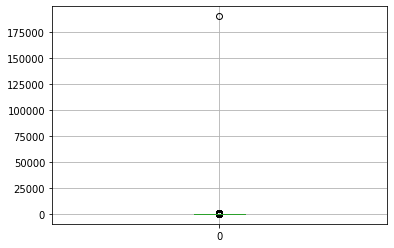

In [6]:
order_number = data.groupby(['id_card_int']).size()
pd.DataFrame(order_number).boxplot()

That's for sure is an outlier.

In [7]:
too_frequent_customers = order_number[order_number > 175000].index.to_list()
too_frequent_customers

[883386]

<AxesSubplot:>

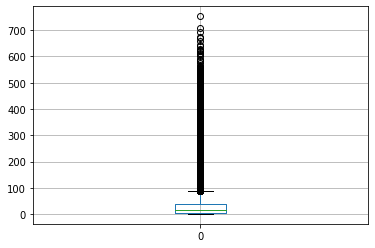

In [8]:
pd.DataFrame(order_number[order_number < 25000]).boxplot()


Others looks ok. 800 items per month is not much

Ok, now we can check total sums of orders 

<AxesSubplot:>

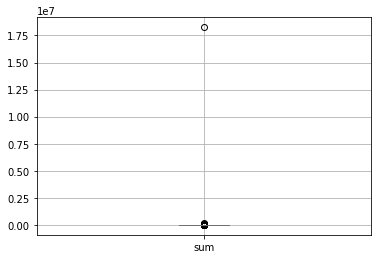

In [9]:
total_order_sum = data[['sum', 'id_card_int']].groupby('id_card_int').sum()
pd.DataFrame(total_order_sum).boxplot()


In [10]:
too_rich_people = total_order_sum[total_order_sum['sum'] > 1e7].index.to_list()
too_rich_people

[883386]

In [11]:
outlier_customers.update(too_rich_people)

As was expected, this is the same customer. Looks like outlier
But what if we will discard it?

<AxesSubplot:>

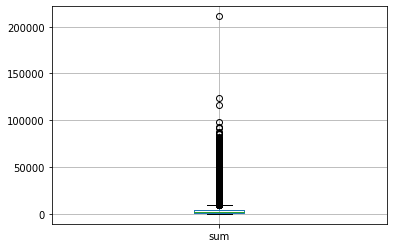

In [12]:
pd.DataFrame(total_order_sum[total_order_sum < 1e7]).boxplot()

Others look ok. They spent slightly less 200k in September.

What about too frequent daily shopping?

In [13]:
daily_receipts_number= pd.DataFrame(data.groupby(['id_card_int', 'day'])['id_doc_int'].nunique())

<AxesSubplot:>

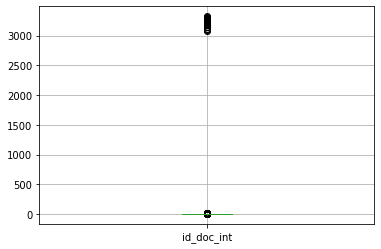

In [14]:
daily_receipts_number.boxplot()

In [15]:
daily_receipts_number[daily_receipts_number > 20]['id_doc_int'].dropna()

id_card_int  day       
883386       2020-09-01    3181.0
             2020-09-02    3197.0
             2020-09-03    3241.0
             2020-09-04    3225.0
             2020-09-05    3105.0
             2020-09-06    3083.0
             2020-09-07    3223.0
             2020-09-08    3259.0
             2020-09-09    3246.0
             2020-09-10    3253.0
             2020-09-11    3210.0
             2020-09-12    3115.0
             2020-09-13    3097.0
             2020-09-14    3239.0
             2020-09-15    3285.0
             2020-09-16    3254.0
             2020-09-17    3258.0
             2020-09-18    3236.0
             2020-09-19    3149.0
             2020-09-20    3146.0
             2020-09-21    3264.0
             2020-09-22    3323.0
             2020-09-23    3293.0
             2020-09-24    3299.0
             2020-09-25    3296.0
             2020-09-26    3186.0
             2020-09-27    3172.0
             2020-09-28    3306.0
             2020-09-29 

As can be seen, 883386 goes to the store very frequently. Obviously...
Let's discard it

<AxesSubplot:>

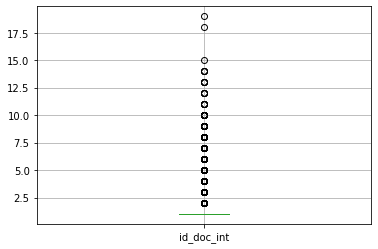

In [16]:
daily_receipts_number[daily_receipts_number <= 20].boxplot()


Looks ok

In [17]:
result = pd.DataFrame(outlier_customers, columns=['id_card_int'])
with open("fake_customers.pkl", 'wb') as f:
    pickle.dump(result, f)